# Reverse-mode "Adjoint" Differentiation Through an ODE Solution
### Example 11.3
We are given a scalar ODE, with solution $u \in \mathcal{R}$, parameters $p \in \mathcal{R}^3$, and defined by:
$$
u_t = f(u, p, t) = p_1 + p_2 u + p_3 u^2 = \langle p, [1, u, u^2] \rangle
$$
The initial condition is $u_0 = 0$.

# Solve with Scipy

In [1]:
from scipy.integrate import solve_ivp
import numpy as np

In [2]:
def f(u, p):
    return np.array([u_vec(u) @ p])

def u_vec(u):
    return np.concatenate([[1.], u, u**2])

p0 = np.array([1., 2., 3.]) * 0.1

u0 = np.array([0.0])

assert f(u0, p0).shape == u0.shape

In [3]:
def u(p, show=False, dense=False):
    sol = solve_ivp(
        fun=lambda t, u: f(u, p),
        t_span=(0, 1),
        y0=u0,
        dense_output=True
    )
    if dense:
        return sol.sol
    if show:
        print(sol)
    ts = np.linspace(0, 1)
    return ts, sol.sol(ts)[0]

assert u(p0, dense=True)(0.723872387) is not None

In [4]:
ts, us = u(p0, show=True)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-04  1.100e-03  1.110e-02  1.111e-01
             1.000e+00]
        y: [[ 0.000e+00  1.000e-05  1.100e-04  1.111e-03  1.124e-02
              1.119e-01]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x10fc95760>
 t_events: None
 y_events: None
     nfev: 32
     njev: 0
      nlu: 0


# Plot

In [5]:
import matplotlib.pyplot as plt

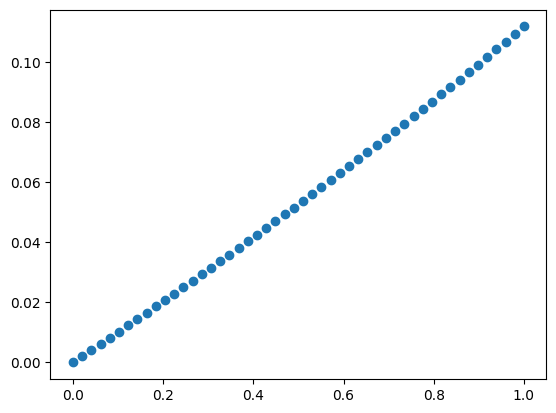

In [6]:
plt.scatter(ts, us)

# Evaluate Loss Functional
Given by $$G(p) = \int_0^T (u(p, t) - t^3)^2 dt $$

In [7]:
from scipy.integrate import trapezoid

def G(p, show=False):
    ts, us = u(p=p, show=show)
    if show:
        print(f"len(ts) = {len(ts)}")
    gs = (us - ts**3)**2
    return trapezoid(gs, ts)

G(p0, show=True)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-04  1.100e-03  1.110e-02  1.111e-01
             1.000e+00]
        y: [[ 0.000e+00  1.000e-05  1.100e-04  1.111e-03  1.124e-02
              1.119e-01]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x1292e8e30>
 t_events: None
 y_events: None
     nfev: 32
     njev: 0
      nlu: 0
len(ts) = 50


0.10309318796550947

# Find Gradient To Minimize Loss

We have no analytical form for the jacobian vector $\frac{\partial u}{\partial p}$, but we can find it using another ODE solve.

Since we know that $$u_t = f$$ we can derive w.r.t $p$, and exchange the derivative order.
$$
(u_p)_t = f_u u_p + f_p
$$
Where $u_p, f_p \in \mathcal{R}^3$, $f_u$ and is a scalar.

$$
\begin{align*}
f_u = p_2 + 2 p_3 u \\
f_p = [1, u, u^2]
\end{align*}
$$

We also know that $u_0 = 0$, so $(u_0)_p = 0$, too.

In [8]:
def f2(y, p):
    _, p2, p3 = p
    u = y[:1]
    u_p = y[1:]
    
    u_t = f(u=u, p=p)  # the ODE for u is solved at the same time.
    u_p_t = u_p * (p2 + 2*p3*u) + u_vec(u)
    return np.concatenate((u_t, u_p_t))
        

assert f2(np.ones(4), p=p0).shape == np.ones(4).shape

In [9]:
def u_p(p, show=False):
    sol = solve_ivp(
        fun=lambda t,y: f2(y,p),
        t_span=(0, 1),
        y0=np.zeros(4),
        dense_output=True
    )
    if show:
        print(sol)
    ts = np.linspace(0, 1)
    us = sol.sol(ts)[0, :]
    u_ps = sol.sol(ts)[1:, :]
    return ts, us, u_ps

In [10]:
ts, us, u_ps = u_p(p0, show=True)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-04  1.100e-03  1.110e-02  1.111e-01
             1.000e+00]
        y: [[ 0.000e+00  1.000e-05 ...  1.124e-02  1.119e-01]
            [ 0.000e+00  1.000e-04 ...  1.124e-01  1.132e+00]
            [ 0.000e+00  5.000e-10 ...  6.265e-04  5.847e-02]
            [ 0.000e+00  3.333e-15 ...  4.675e-06  4.188e-03]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x12932f200>
 t_events: None
 y_events: None
     nfev: 32
     njev: 0
      nlu: 0


Plot the 3 dimensions of $u_p$:

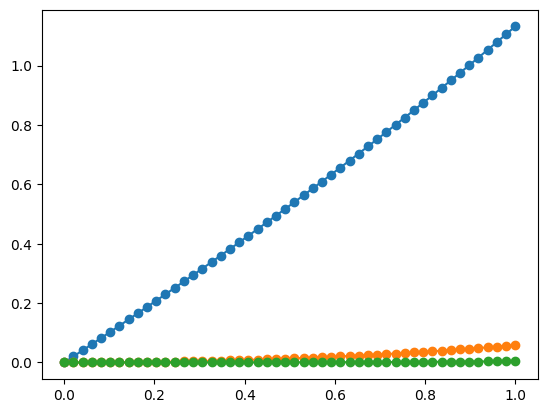

In [11]:
plt.plot(ts, u_ps.T, marker="o")

Now the gradient is:
$$
\nabla_p G = 2 \int_0^T (u(p, t) - t^3) u_p^T dt
$$

In [12]:
def grad(p):
    ts, us, u_ps = u_p(p=p)
    ys = (us - ts**3) * u_ps
    return 2 * trapezoid(ys, ts)

grad(p=p0)

array([-0.36330894, -0.01594253, -0.00098493])

In [13]:
G(p0)

0.10309318796550947

In [14]:
G(p0 - grad(p0))

0.022037469217443904

# Optimize p

In [15]:
p = p0
for idx in range(100):
    p = p - 0.1 * grad(p)
    loss = G(p)
    if idx % 10 == 0:
        print(loss)
forward_p_opt = p
print(f"Final p={forward_p_opt}")

0.09035097446386946
0.031138092958603245
0.020402578682329243
0.018697537331478286
0.018366212787302844
0.018220177310243873
0.018097757838280996
0.017978466048563544
0.017859826212809744
0.017741557601288774
Final p=[0.51988734 0.33822312 0.35674389]


In [16]:
def plot_u(p):
    ts, us = u(p)
    plt.plot(ts, us)
    plt.plot(ts, ts**3)

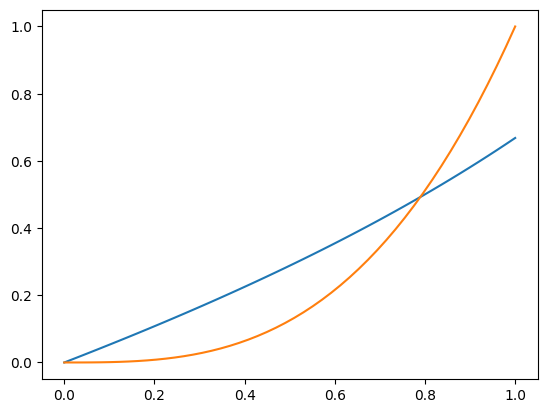

In [17]:
plot_u(p)

The blue curve for $u(p, t)$ is the ODE solution for optimal $p^*$. The curve comes close to the $t^3$ curve. The crux is that the curve satisfies the ODE defined by $f$ in the beginning, and the initial condition $u_0=0$.

# Reverse-Mode Differentiation

The adjoint ODE is:
$$
\begin{align*}
v_t 
&= g_u^T - f_u^T v \\
&= 2 (u - t^3) - (p_2 + 2 p_3 u) v
\end{align*}
$$

In [18]:
class Ode2:
    def __init__(self, p):
        self.p = p
        self.u_fn = u(p=p, dense=True)
        assert self.u_fn(0.12313)

    def f3(self, t, v):
        _, p2, p3 = self.p
        u = self.u_fn(t)
        v_t = 2*(u-t**3) -(p2 + 2*p3*u)*v
        return v_t

assert Ode2(p0).f3(0.0, np.zeros(1)).shape == np.zeros(1).shape

def v(p, show=False):
    ode = Ode2(p)
    sol = solve_ivp(
        fun=ode.f3,
        t_span=(1, 0),
        y0=np.zeros(1),
        dense_output=True
    )
    if show:
        print(sol)
    ts = np.linspace(0, 1)
    us = ode.u_fn(ts)
    vs = sol.sol(ts)[0]
    
    # assert np.isclose(0.0, vs[-1]), vs[-1]
    
    return ts, us, vs

assert v(p0) is not None

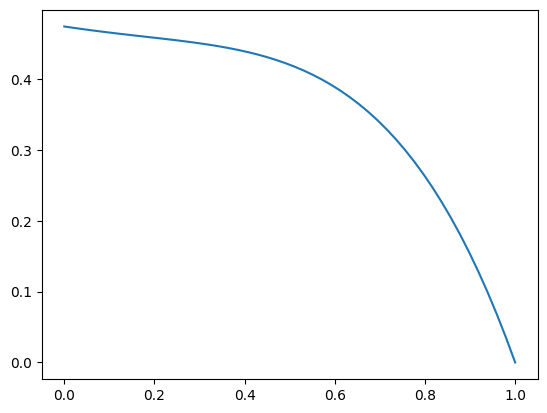

In [19]:
def plot_v(p):
    ts, us, vs = v(p)
    plt.plot(ts, vs)

plot_v(p0)

In [20]:
def grad2(p, show=False):
    ts, us, vs = v(p=p, show=show)
    es = np.vstack([np.ones_like(us), us, us**2]) * vs
    return -trapezoid(es, ts)

Now optimize:

In [21]:
p = p0
for idx in range(100):
    p = p - 0.1 * grad2(p)
    loss = G(p)
    if idx % 10 == 0:
        print(loss)
reverse_p_opt = p
print(f"Final p={reverse_p_opt}")

0.09036291343432583
0.031175814842601245
0.02042169929003144
0.01870573915679095
0.01837055157911647
0.01822352246183525
0.01810110776094997
0.01798215700192219
0.01786396978727
0.017746189235262548
Final p=[0.51971024 0.33781044 0.35644083]


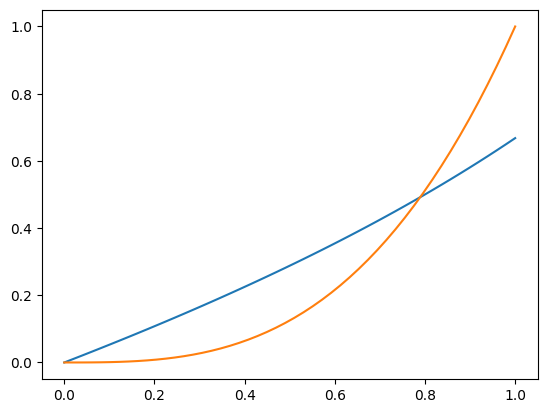

In [22]:
plot_u(p)

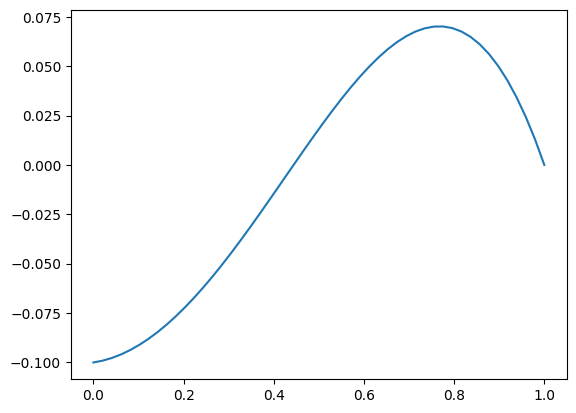

In [23]:
plot_v(p)

# Comparison
* Both modes (forward- and reverse-mode differentation) produce grads that reduce the loss $G(p)$.
* However, notice that in forward-mode we compute $u_p$, which is a 3-dimensional vector, and we integrate this vector from 0 to 1.
* In reverse-mode we computed $v$ which is a scalar, and integrate the scalar from 0 to 1.
* When the dimensionality of the ODE grows, forward-mode will always be of size $n$, while reverse-mode will be of size 1 (assuming the loss is a scalar).

**Numerical proof:** both forward- and reverse-mode gradients are equivalent, the optimiums reached are equivalent, as well as the loss.

In [24]:
grad(p0), grad2(p0)

(array([-0.36330894, -0.01594253, -0.00098493]),
 array([-0.36295583, -0.01591441, -0.00098264]))

In [25]:
forward_p_opt, reverse_p_opt

(array([0.51988734, 0.33822312, 0.35674389]),
 array([0.51971024, 0.33781044, 0.35644083]))

In [26]:
G(forward_p_opt), G(reverse_p_opt)

(0.017635412527476437, 0.017640491902060303)